In [1]:
# # !!! only uncomment and run when using colab !!!
import os
! git clone https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox # downloading the source code
os.chdir("/content/CPlantBox/")
! git pull
! cmake .
! make
os.chdir("/content/CPlantBox/tutorial/jupyter/crop_in_silico_2022/")

Cloning into 'CPlantBox'...
remote: Enumerating objects: 15710, done.
remote: Counting objects: 100% (1284/1284), done.
remote: Compressing objects: 100% (863/863), done.
remote: Total 15710 (delta 472), reused 1191 (delta 411), pack-reused 14426
Receiving objects: 100% (15710/15710), 564.77 MiB | 22.93 MiB/s, done.
Resolving deltas: 100% (10124/10124), done.
Checking out files: 100% (1581/1581), done.
Already up to date.
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found PythonInterp: /usr/bin/python3.7 (found suitable version "3.7.

# Crop in silico - 2022

In [4]:
import sys; sys.path.append("../../.."); sys.path.append("../../../src/python_modules")
import plantbox as pb
#import vtk_plot as vp # for quick 3d vizualisations
import matplotlib.pyplot as plt # for 2d plots
import numpy as np
import pandas as pd
from plotnine import *

## 1. Simulate a root system

In [10]:
# Create instance describing a root system
rs = pb.RootSystem()

# Open plant and root parameter from a file
path = "../../../modelparameter/rootsystem/"
name = "Zea_mays_1_Leitner_2010"
rs.readParameters(path + name + ".xml")

# Simulate
rs.initialize() 
rs.simulate(30) # [days]

# Export
ana = pb.SegmentAnalyser(rs)
ana.write("first_example.txt") # e.g. gui/viewer/rsml_viewer.py


### Visualize the root system

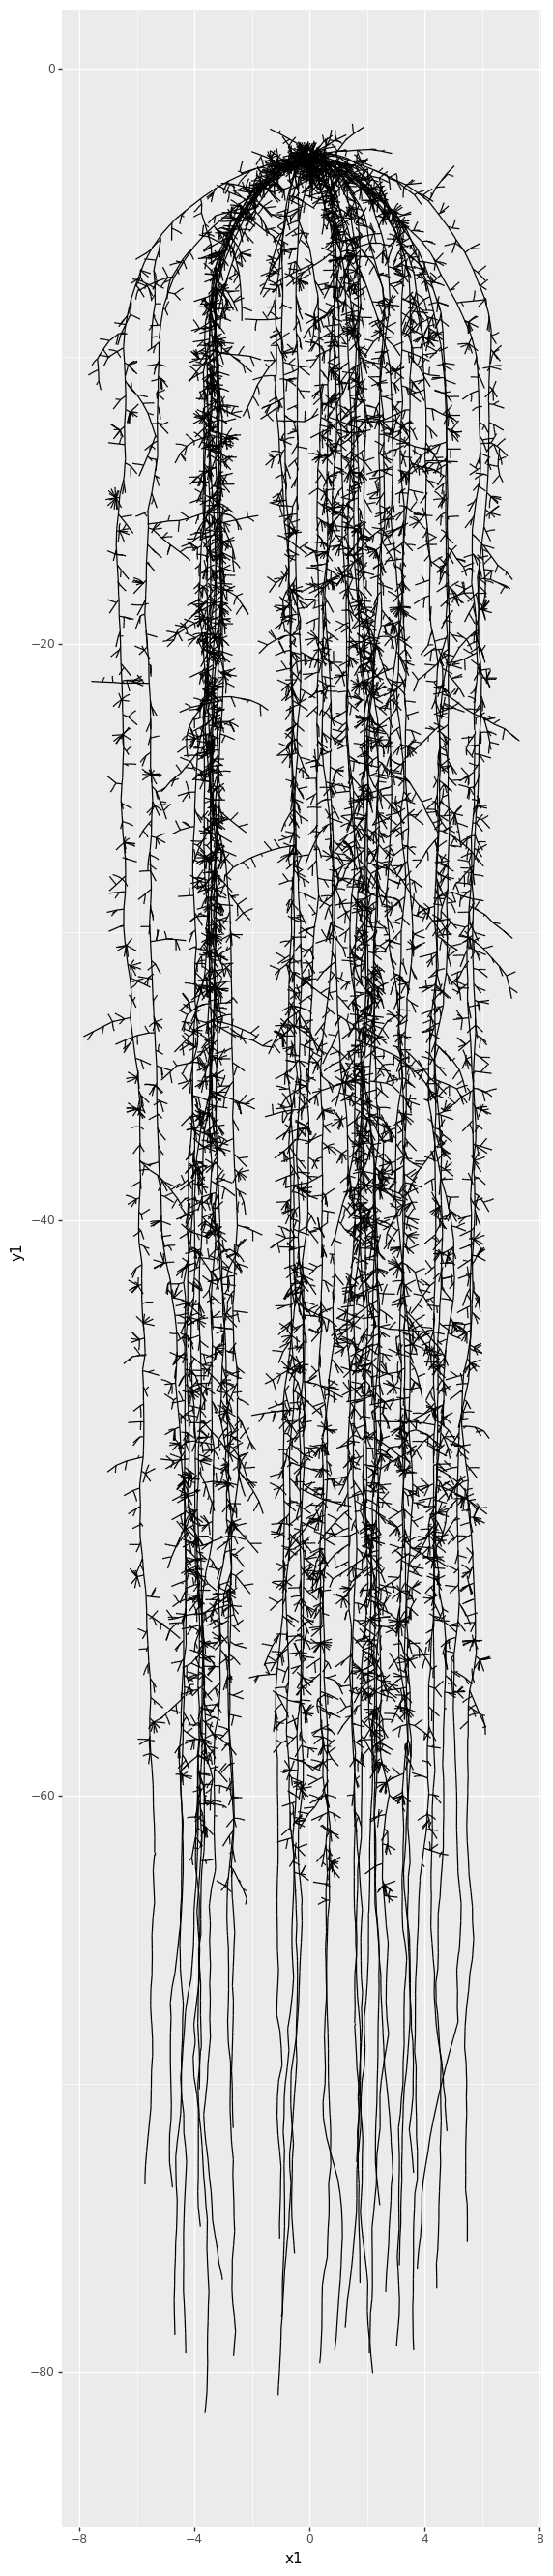

<ggplot: (8745650837785)>

In [11]:
dat = pd.read_csv("first_example.txt", sep=" ")


%matplotlib inline

(ggplot(dat)         # defining what data to use
 + aes()    # defining what variable to use
 + geom_segment(aes(x = "x1", y = "y1", xend = "x2", yend = "y2"))
 + coord_fixed()
)

## 2. Post-processing (how to evaluate simulation results)

Basically, there are two methods 

1. Using class *RootSystem* directly, parameter values are given per root (root system is represented as polylines).

2. Using class *SegmentAnalyser*, which will consider all segments of the root system, parameter values are given per segment (root system is represented by nodes and segments).

### 2.1 Root system length vs time

A typical simulation loop will look like

The following example will plot length versus time for the root system, and each subType (see *example2d_length.py*

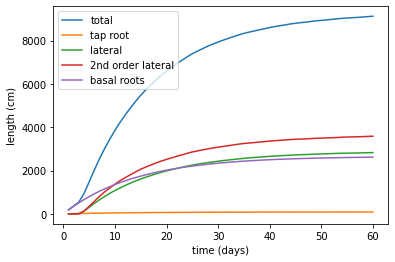

final tap root length:  87.12985833706756 cm


In [9]:
rs.initialize() # reset above simulation
scalar_type = "length" # "surface", "volume"
v_, v1_, v2_, v3_, v4_ = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)

""" Simulation loop """
for i in range(0, N):
    rs.simulate(dt)
    t = np.array(rs.getParameter("subType")) # value per root
    v = np.array(rs.getParameter(scalar_type)) # all random or specific parameters are accessible
    v_[i] = np.sum(v)
    v1_[i] = np.sum(v[t == 1])
    v2_[i] = np.sum(v[t == 2])
    v3_[i] = np.sum(v[t == 3])
    v4_[i] = np.sum(v[t == 4])
    
t_ = np.linspace(dt, N * dt, N)
plt.plot(t_, v_, t_, v1_, t_, v2_, t_, v3_, t_, v4_)
plt.xlabel("time (days)")
plt.ylabel(scalar_type + " (cm)")
plt.legend(["total", "tap root", "lateral", "2nd order lateral", "basal roots"])
# plt.savefig("myplot.png") # we could save it as png
plt.show()
print("final tap root length: ", v1_[-1], "cm")

## 2.2 Analyse results from the class *SegmentAnalyser* (values per segment) in a loop

The main functionality of the *SegmentAnalyser* class is:
* *getParameter(name)* as for *RootSystem* class, but returning a value for each segment, especially the "creationTime" of each segment
* *filter(name, min, max)* will keep only segments where the value of parameter *name* is within [min, max]
* *crop(sdf)* will keep only segments inside a geometry (e.g. in a soil core), segments intersecting the domain boundary are cut. 
* *distribution(...)* will create a 1d plot versus depth, where parameters are summed in layers 
* *distribution2d(...)* as above but 2d
* *mapPeriodic(length, width)* maps the unconstrained root system into a periodic domain
* *addData(name, data)* attach user data to the segments (e.g. simulation results for visualization or export)

Note that *SegmentAnalyser* is only loosly connected to the original simulation.

The first example shows how to obtain a depth distribution (values per segment) in a simulation loop.

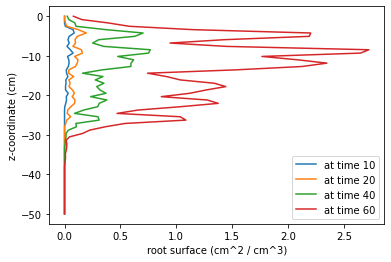

In [ ]:
s = pb.RootSystem()
path = "../../../modelparameter/rootsystem/"
name = "Lupinus_albus_Leitner_2014"
rs.readParameters(path + name + ".xml")
rs.setGeometry(pb.SDF_PlantBox(1.e6,1.e6,1.e6)) 
rs.initialize()

simtimes = [0,10,20,40,60] # day
dt_ = np.diff(simtimes) # day
depth = 50 # cm
layers = 60 # [1]

""" Simulation loop """
rsd_ = []
for dt in dt_:    
    rs.simulate(dt)
    # _ = vp.plot_roots(rs, "subType") # to observe growth
    ana = pb.SegmentAnalyser(rs) # create a SegmentAnalyser object
    rsd = ana.distribution("surface", 0., -depth, layers, True)
    rsd_.append(rsd) # store relevant data in a list

""" vizualize rld_ """
soilvolume = (depth / layers) * 10 * 10
rsd_ = np.array(rsd_) / soilvolume  # convert to density [cm2/cm3]

z_ = np.linspace(0, -depth, layers)  # z - axis
for i, t in enumerate(simtimes[1:]):
    plt.plot(rsd_[i,:], z_, label = "at time "+str(t))

plt.xlabel("root surface (cm^2 / cm^3)")
plt.ylabel("z-coordinate (cm)")
plt.legend()
# plt.savefig("surface_density.png")
plt.show()
# _ = vp.plot_roots(rs, "subType") # final result